In [1]:
import json
import math
import copy
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as lines
import geopandas as gpd
from shapely.geometry import Polygon, LineString, Point as Point_geom
from sympy import Line, Point
from descartes.patch import PolygonPatch

output_file_ [3, 10, 14, 37, 61, 104, 196, 285, 346, 661, 905]

In [2]:
%%time
# Выгрузка данных о препятствиях из программы-генератора
with open('ATP_generator/output_file_285.json', 'r') as f:
    output = json.load(f)
info = output[0]
startPoint = [output[1]['x'], output[1]['y']]
endPoint = [output[2]['x'], output[2]['y']]

# Массив, хранящий координаты вершин полигонов
polygon_arr = []
for inf_dict in output:
    arr = []
    if inf_dict['type'] == 'polygon':
        [arr.append([point['x'], point['y']]) for point in inf_dict['points']]
        polygon_arr.append(arr)
        
arr = []
[arr.append (Polygon(polygon)) for polygon in polygon_arr]

# Массив, хранящий координаты отрезков, являющихся продолжением сторон полигонов до пересечения их с границами пространства
lines_xxyy = []
for polygon in polygon_arr:
    lines_xx = []
    for start_i in range(len(polygon)):
        # координаты 1-ой вершины:
        x1 = polygon[start_i][0]
        y1 = polygon[start_i][1]
        # соединяем с соседними вершинами (сторона полигона)
        for end_i in [start_i-1, start_i+1]:
            if end_i == -1:
                end_i = len(polygon) - 1
            if end_i == len(polygon):
                end_i = 0
            x2 = polygon[end_i][0]
            y2 = polygon[end_i][1]
            # сторона лежит на границе пр-ва:
            if (x1==x2==0 or x1==x2==100 or y1==y2==0 or y1==y2==100):
                continue
            if (x1 == x2):    # вертикальные отрезки
                x_y0 = x_y100 = x1
                y_x0 = y_x100 = -100
            elif (y1 == y2):  # горизонтальные отрезки
                y_x0 = y_x100 = y1
                x_y0 = x_y100 = 200
            else: 
                x_y0 = (y1*x2-y2*x1)/(y1-y2) # y=0
                x_y100 = (x1*(100-y2)-x2*(100-y1))/(y1-y2) # y=100
                y_x0 = (y2*x1-y1*x2)/(x1-x2) # x=0
                y_x100 = (y1*(100-x2)-y2*(100-x1))/(x1-x2) # x=100

            points = [[]]*2 # координаты точек пересечения с конф. пр-вом (две точки)
            # выбираем из 4-х возможных точек те, которые пересекают прямые (x=[0,100],y=[0,100]) на границах конф-пр-ва
            if y_x0 >= 0 and y_x0 <= 100:
                if len(points[0]) == 0:
                    points[0] = [0,y_x0]
                else:
                    points[1] = [0,y_x0]
            if y_x100 >= 0 and y_x100 <= 100:
                if len(points[0]) == 0:
                    points[0] = [100,y_x100]
                else:
                    points[1] = [100,y_x100]
            if x_y0 >= 0 and x_y0 <= 100:
                if len(points[0]) == 0:
                    points[0] = [x_y0,0]
                else:
                    points[1] = [x_y0,0]
            if x_y100 >= 0 and x_y100 <= 100:
                if len(points[0]) == 0:
                    points[0] = [x_y100,100]
                else:
                    points[1] = [x_y100,100]
            # сохраняем координаты двух отрезков для продолжения одной стороны
            err = 10**(-10) # допустимая погрешность
            for point in points:  
                l1 = math.hypot(x1-point[0], y1-point[1])
                l2 = math.hypot(x2-point[0], y2-point[1])
                if l1<=l2 and l1!=0 and l1>err:
                    coord = [[point[0],x1],[point[1],y1]]
                elif l2<=l1 and l2!=0 and l2>err: 
                    coord = [[point[0],x2],[point[1],y2]]
                if coord not in lines_xx:
                    lines_xx.append(coord)
    lines_xxyy.append(lines_xx)

# lines_xxyy: [[x1,x2],[y1,y2]] <-> lines_xyxy: [[x1,y1],[x2,y2]]
lines_xyxy=[]
for polygon in lines_xxyy:
    lines_xy = []
    for line in polygon:
        l = copy.deepcopy(line)
        l[0][1] = line[1][0]
        l[1][0] = line[0][1]
        lines_xy.append(l)
    lines_xyxy.append(lines_xy)

# Массив, хранящий координаты отрезков, являющихся продолжением сторон полигонов до пересечения их с границами пространства или другими полигонами
segments_xxyy = []
for polygon1 in range(len(lines_xxyy)):
    segments_xx = []
    for line_index in range(len(lines_xyxy[polygon1])): # отрезки - продолжение сторон рассматриваемого полигона
        line = LineString(lines_xyxy[polygon1][line_index])
        line_coord = []
        for polygon2 in range(len(arr)):                # полигон, который проверяется на пересечение отрезком
            if polygon1 != polygon2:
                points = line.intersection(arr[polygon2]).coords[:]
                if len(points) != 0:
                    line_coord.append(points)
            line_polygon = [[],[]]
            for i in lines_xyxy[polygon1][line_index]:  # смотрим концы отрезка: сохраняем координату, лежащую внутри конф. пр-ва
                if i[0] not in [0,100] and i[1] not in [0,100]:
                    line_polygon[0] = i
                else:
                    line_polygon[1] = i
            if line_polygon[0] == []:
                print("line_polygon:",line_polygon) 
                print("polygon1=",polygon1)
                print("line_index=",line_index)
            min_dist = 200
            
            if len(line_coord) > 0:                     # если были пересечения с препятствиями
                for polygon_intersect in line_coord:
                    for point_intersect in polygon_intersect:
                        cur_dist = math.hypot(point_intersect[0]-line_polygon[0][0], point_intersect[1]-line_polygon[0][1])
                        if cur_dist < min_dist:
                            min_dist = cur_dist
                            line_polygon[1] = [point_intersect[0],point_intersect[1]]
        segments_xx.append([[line_polygon[0][0],line_polygon[1][0]],[line_polygon[0][1],line_polygon[1][1]]])
    segments_xxyy.append(segments_xx)

# Массив, хранящий середины отрезков
segments_mid = []
for polygon in segments_xxyy:
    for line in polygon:
        polygon_node = False
        mid = [(line[0][0]+line[0][1])/2, (line[1][0]+line[1][1])/2]
        intersect = False # проверка на пересечение препятствий
        for pol in arr:
                if pol.contains(Point_geom(mid)):
                    intersect = True
        for p in polygon_arr:
            if mid in p:
                polygon_node = True
        if not(intersect) and not polygon_node:
            segments_mid.append(mid)

# Матрица расстояний между вершинами (содержит стартовую и целевую точки)
segments_mid.sort()
segments_mid.append(startPoint)
segments_mid.append(endPoint)

mid_dist = []
for point1 in segments_mid:
    point_dist = []
    for point2 in segments_mid:
        dist = (point1[0]-point2[0])**2+(point1[1]-point2[1])**2
        point_dist.append(dist)
    mid_dist.append(point_dist)

# Построение графа по получнным точкам
edges_xxyy = [[] for i in range(len(segments_mid))]
p2_i = 0
print("len=",len(segments_mid))

separate = False              # Флаг: обрабатываем вершину вне графа (строим два ребра: к свободной точке и к вершине в графе)
separate_arr = []             # Массив: индексы вершин, которые не могут быть присоединены к графу
connected_arr = []            # Массив: индексы вершин, которые уже соединены ребром
for i in range(len(segments_mid)): # Цикл: для каждой построенной точки
    # print("i=",i)
    p1_i = p2_i               # Индекс первой вершины для соединения
    p1 = segments_mid[p1_i]   # Координаты первой вершины
    j = 1                     # стараемся соединить с первым узлом в отсортированном массиве расстояний (с ближайшим)
    to_graph = False          # Флаг: нет возможности провести ребро к свободной точке -> соединяем с вершиной в графе
    already_connected = []    # Массив ближайших точек, которые уже соединены ребрами
    k = 1
    if separate:
        k = 2
    separate = False
    while len(edges_xxyy[p1_i]) < k:       # Цикл: пока не построем одно (два) ребра от рассматриваемой точки
        connect = True                     # Флаг: можно провести ребро
        if k == 2 and len(edges_xxyy[p1_i]) == 1:
            connect = False
            if len(already_connected) >= 2:
                to_graph = True
        if j >= len(mid_dist[p1_i]):
            to_graph = True
        else:
            p2_i = mid_dist[p1_i].index(sorted(mid_dist[p1_i])[j])
            p2 = segments_mid[p2_i]
        for segment in edges_xxyy[p2_i]:    # Проверка на наличие ближайшей точки в графе
            if p2[0] in segment[0] and p2[1] in segment[1]:
                if p2 not in already_connected:
                    already_connected.append(p2)
                connect = False
        line = LineString([p1,p2])

        for polygon in range(len(arr)):    # Проверка на пересечение препятствий ребром
            p = line.intersection(arr[polygon])
            if str(type(p)) != "<class 'shapely.geometry.multilinestring.MultiLineString'>":
                points = p.coords[:]
            if len(points) != 0 or str(type(p)) == "<class 'shapely.geometry.multilinestring.MultiLineString'>":
                if p2 in already_connected:
                    del already_connected[already_connected.index(p2)]
                connect = False
        if connect:                        # Проводим ребро, если можно
            edges_xxyy[p1_i].append([[p1[0],p2[0]],[p1[1],p2[1]]])
            if p2_i not in connected_arr:
                connected_arr.append(p2_i)
        else:                              # Если нельзя провести ребро, проверяем следующую по близости вершину
            j += 1
            
        if to_graph:                       # Если точку нужно соединить с уже построенным графом
            if len(already_connected) == 0 and j >= len(mid_dist[p1_i]):
                if p1_i not in separate_arr:
                    separate_arr.append(p1_i) 
                p2_i = -1
                for i in range(len(edges_xxyy)):
                    if len(edges_xxyy[i]) == 0 and i != p1_i and i not in separate_arr:
                        p2_i = i
                        separate = True
                        break                          
                p2_prev = -1
                for i in range(len(edges_xxyy)):
                    if len(edges_xxyy[i]) == 0 and i != p1_i and i not in separate_arr and i not in connected_arr:
                        p2_prev = i
                        break 
                if p2_prev == -1:
                    p2_i = p2_prev
                break
            if len(already_connected) > 1:
                p2 = already_connected[1]
                edges_xxyy[p1_i].append([[p1[0],p2[0]],[p1[1],p2[1]]]) 
                if p2_i not in connected_arr:
                    connected_arr.append(p2_i)         
            # Когда присоединяем вершину к уже построенному графу, следующую вершину берем, исходя из того, что для нее не заполнен edges_xxyy
            p2_prev = -1
            for i in range(len(edges_xxyy)):
                if len(edges_xxyy[i]) == 0 and i != p1_i and i not in separate_arr:
                    p2_prev = i
                    separate = True
                    break  
            p2_i = -1
            for i in range(len(edges_xxyy)):
                if len(edges_xxyy[i]) == 0 and i != p1_i and i not in separate_arr and i not in connected_arr:
                    p2_prev = i
                    break 
            if p2_i == -1:
                p2_i = p2_prev
            break
                
# Замыкание графа (добавляем второе ребро к первой вершине)
p1_i = 0
p1 = segments_mid[p1_i]
j = 2
while len(edges_xxyy[p1_i]) < 2:
    connect = True
    p2_i = mid_dist[p1_i].index(sorted(mid_dist[p1_i])[j])
    p2 = segments_mid[p2_i]
    line = LineString([p1,p2])
    for polygon in range(len(arr)):
        points = line.intersection(arr[polygon]).coords[:]
        if len(points) != 0:
            connect = False
    if connect:
        edges_xxyy[p1_i].append([[p1[0],p2[0]],[p1[1],p2[1]]])
    else:
        j += 1

# Получение ключа по значению в словаре
def get_key(d, value):
    for k, v in d.items():
        if v == value:
            return k

# Построение матрицы смежности для полученного графа
G_init = []
G_dict = {x+1: [] for x in range(len(segments_mid))} # Словарь: {номер вершины: координаты}      
for node_i in range(len(segments_mid)):
    G_dict[node_i+1] = segments_mid[node_i]
for node_i in range(len(edges_xxyy)):    
    for node_j in range(len(edges_xxyy[node_i])):
        j = get_key(G_dict,[edges_xxyy[node_i][node_j][0][1], edges_xxyy[node_i][node_j][1][1]])
        G_init.append((node_i+1,j))
        G_init.append((j,node_i+1))
G = nx.DiGraph()
G.add_edges_from(G_init)

# Функция, реализующая алгоритм Ли
def Li_wave(G, start, goal):
    result = [start, goal]
    mark = [-1 for node in G.nodes()]
    neighbors_to = [[next_node for next_node in G.successors(node)] for node in sorted(nx.nodes(G))]    
    neighbors_from = [[prev_node for prev_node in G.predecessors(node)] for node in sorted(nx.nodes(G))]
    sender = start
    mark[sender-1] = 1
    for neighbor in neighbors_to[sender-1]:
            if mark[neighbor-1] == -1:
                mark[neighbor-1] =  mark[sender-1] + 1
    new_senders = [neighbor for neighbor in neighbors_to[sender-1]]
    
    # Wafe spread:    
    while mark[goal-1] == -1:
        senders = new_senders.copy()
        new_senders = []
        while len(senders) > 0:
            sender = senders[0]
            del senders[0]
            for neighbor in neighbors_to[sender-1]:
                if mark[neighbor-1] == -1:
                    mark[neighbor-1] =  mark[sender-1] + 1
                    new_senders.append(neighbor)        
    # Result path:
    prev_node = goal
    level = mark[goal-1]
    while level != 1:
        for i in range(len(mark)):
            if mark[i] == level - 1 and i+1 in neighbors_from[prev_node-1]:
                prev_node = i+1
        level -= 1
        result.append(prev_node)   
    return(result)

# Поиск маршрута
result = Li_wave(G, len(segments_mid)-1, len(segments_mid))
result_nodes = []
for i in result:
    result_nodes.append(G_dict[i])

len= 542
CPU times: total: 30.2 s
Wall time: 31.2 s


In [3]:
n = 0
for p in polygon_arr:
    for k in p:
        n += 1
n

285

C:\Users\artyu\anaconda3\lib\site-packages\descartes\patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


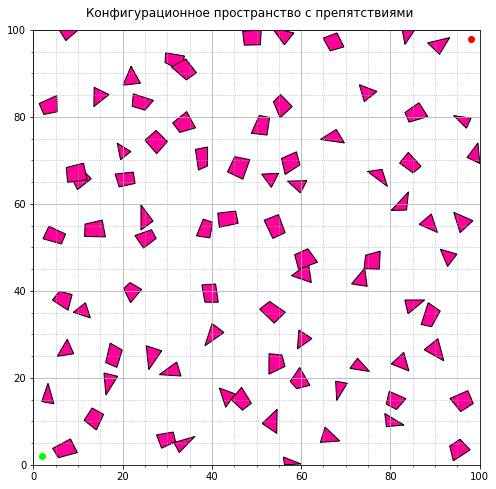

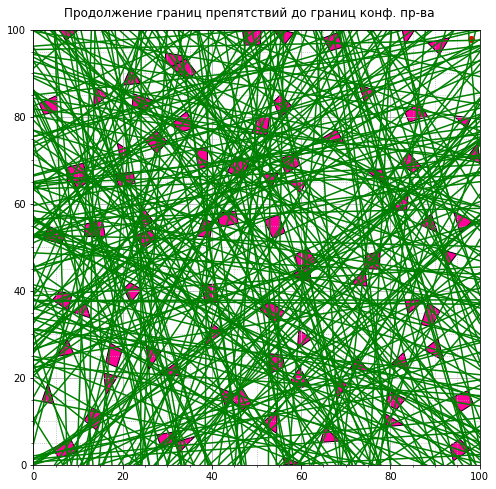

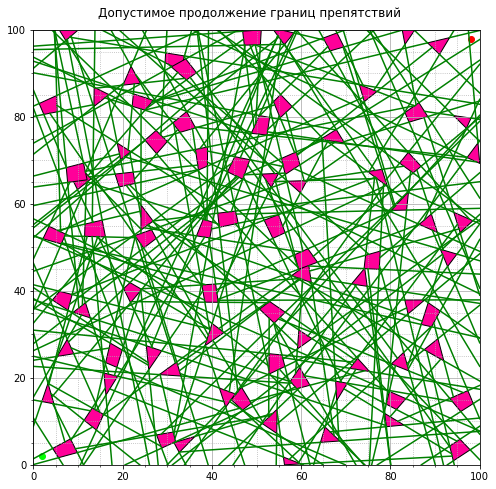

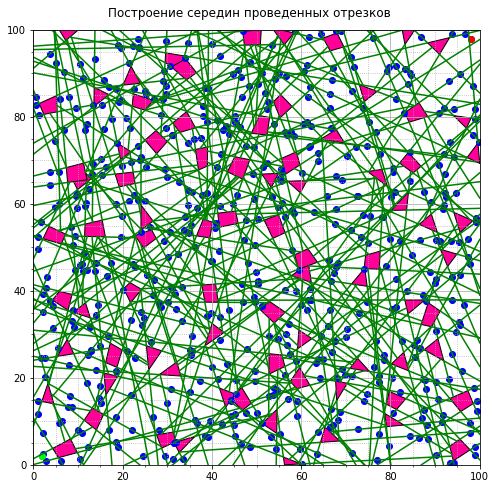

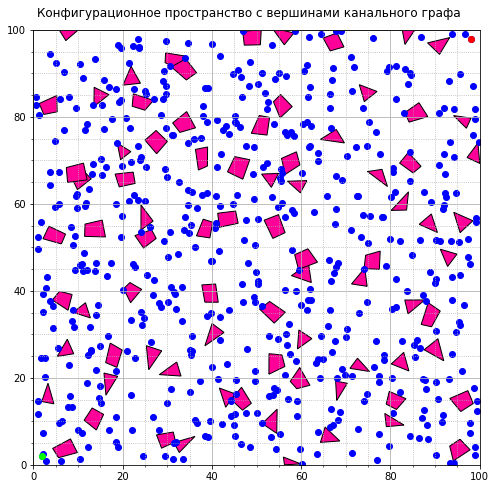

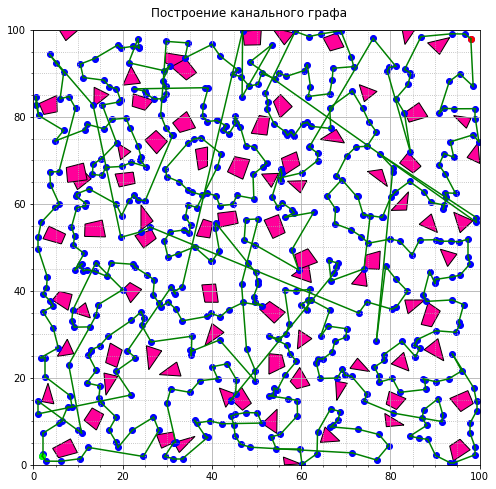

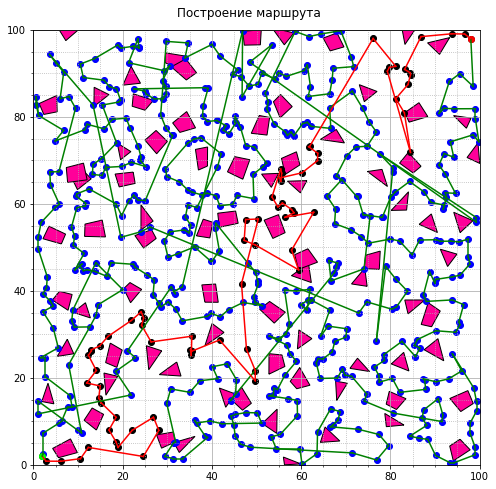

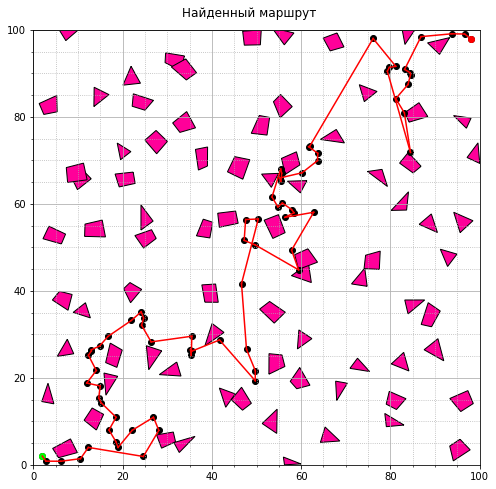

In [4]:
steps = {x+1: '' for x in range(8)}
steps[1] = 'Конфигурационное пространство с препятствиями'
steps[2] = 'Продолжение границ препятствий до границ конф. пр-ва'
steps[3] = 'Допустимое продолжение границ препятствий'
steps[4] = 'Построение середин проведенных отрезков'
steps[5] = 'Конфигурационное пространство с вершинами канального графа'
steps[6] = 'Построение канального графа'
steps[7] = 'Построение маршрута'
steps[8] = 'Найденный маршрут'

# Отрисовка графа
for key in steps.keys():
    plt.figure(figsize=(8, 8))
    ax = plt.axes()
    border = Polygon([[0, 0], [0, 100], [100, 100], [100, 0]])
    # ax.add_patch(PolygonPatch(border, facecolor=[1,0.8,1]))
    ax.add_patch(PolygonPatch(border, facecolor=[1,1,1]))
    for poly in arr:
        ax.add_patch(PolygonPatch(poly, facecolor=[1,0,0.6]))
    ax.minorticks_on()
    plt.grid(which='major')
    plt.grid(which='minor', linestyle=':')

    if key == 2:
        for polygon in lines_xxyy:
            for segment in polygon:
                line = lines.Line2D(segment[0],segment[1],color ='green')
                ax.add_line(line)
    elif key ==3:
        for polygon in segments_xxyy:
            for segment in polygon:
                line = lines.Line2D(segment[0],segment[1],color ='green')
                ax.add_line(line)
    elif key ==4:
        for polygon in segments_xxyy:
            for segment in polygon:
                line = lines.Line2D(segment[0],segment[1],color ='green')
                ax.add_line(line)
        for mid in segments_mid:
            plt.scatter(mid[0],mid[1], facecolor=[0,0,1])
    elif key ==5:
        for mid in segments_mid:
            plt.scatter(mid[0],mid[1], facecolor=[0,0,1])
    elif key ==6:
        for polygon in edges_xxyy:
            for segment in polygon:
                line = lines.Line2D(segment[0],segment[1],color ='green')
                ax.add_line(line)
        for mid in segments_mid:
            plt.scatter(mid[0],mid[1], facecolor=[0,0,1])
    elif key ==7:
        for polygon in edges_xxyy:
            for segment in polygon:
                line = lines.Line2D(segment[0],segment[1],color ='green')
                if [segment[0][0],segment[1][0]] in result_nodes and [segment[0][1],segment[1][1]] in result_nodes:
                    line = lines.Line2D(segment[0],segment[1],color ='red')
                else:
                    line = lines.Line2D(segment[0],segment[1],color ='green')
                ax.add_line(line)
        for mid in segments_mid:
            if mid in result_nodes:
                plt.scatter(mid[0],mid[1], facecolor=[0,0,0])
            else:
                plt.scatter(mid[0],mid[1], facecolor=[0,0,1])
    elif key == 8:
            for polygon in edges_xxyy:
                for segment in polygon:
                    line = lines.Line2D(segment[0],segment[1],color ='red')
                    if [segment[0][0],segment[1][0]] in result_nodes and [segment[0][1],segment[1][1]] in result_nodes:
                        ax.add_line(line)
            for mid in segments_mid:
                if mid in result_nodes:
                    plt.scatter(mid[0],mid[1], facecolor=[0,0,0])
                    
    plt.scatter(startPoint[0],startPoint[1], facecolor=[0,1,0])
    plt.scatter(endPoint[0],endPoint[1], facecolor=[1,0,0])
    plt.suptitle(steps[key], y=0.92)
    plt.xlim(0,100)
    plt.ylim(0,100)                            

Зависимость времени выполнения программы от количества вершин препятствий

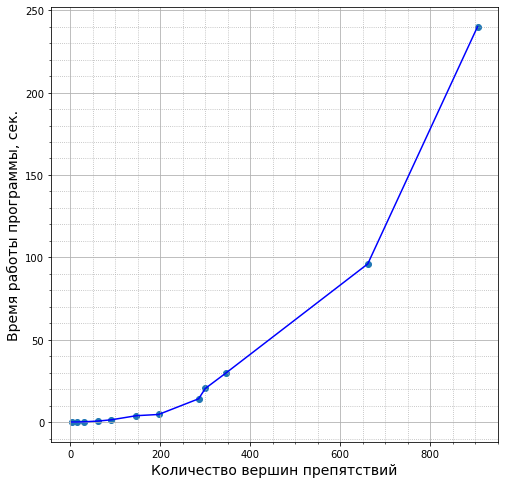

In [5]:
x = [3,14,30,61,91,147,196,285,300,346,661,905]
y = [0.003,0.016,0.156,0.578,1.36,3.86,4.59,14.1,20.4,29.8,96,240]
plt.figure(figsize=(8, 8))
ax = plt.axes()
plt.plot(x, y, 'b')
plt.scatter(x, y)
plt.xlabel('Количество вершин препятствий', fontsize=14)
plt.ylabel('Время работы программы, сек.', fontsize=14)
ax.minorticks_on()
plt.grid(which='major')
plt.grid(which='minor', linestyle=':')
plt.show()